In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from shapely.geometry import MultiPoint, Point, Polygon, box
from scipy.spatial import Voronoi
from scipy.interpolate import griddata

import data

In [7]:
def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max()

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())
        
    return new_regions, np.asarray(new_vertices)



In [10]:
current_density_df_input = pd.read_csv( data.DIR_PATH / 'J_input_term.csv', skiprows=7)
# current_density_df_input = pd.read_csv( data.DIR_PATH / 'J_pos_term.csv', skiprows=7)
current_density_df_input = current_density_df_input.rename(columns={'Normal current density': 'J'})
current_density_df_input

,x,z,J
0,-0.004614,0.000152,721000000.0
1,-0.004638,0.000178,721000000.0
2,-0.004663,0.000203,721000000.0
3,-0.004688,0.000229,721000000.0
4,-0.004713,0.000254,721000000.0
...,...,...,...
2498,0.004589,0.000279,517000000.0
2499,0.004614,0.000305,517000000.0
2500,0.004539,0.000279,517000000.0
2501,0.004564,0.000305,517000000.0


In [25]:
corners_input_terminal = [
    (0.0047625, -0.03227401003, -6.009082121E-15),
    (0.0047625, -0.03227401003, 3.048E-4),
    (-0.0047625, -0.03227401003, -5.981326545E-15),
    (-0.0047625, -0.03227401003, 3.048E-4)
]
# Extract x, y, and z ranges
xmin = min(corner[0] for corner in corners_input_terminal)
xmax = max(corner[0] for corner in corners_input_terminal)
zmin = min(corner[2] for corner in corners_input_terminal)
zmax = max(corner[2] for corner in corners_input_terminal)

y_value = corners_input_terminal[0][1]  # y is constant for all points

x_scaling = xmax - xmin
z_scaling = zmax - zmin

# Interpolation grid
grid_x, grid_z = np.meshgrid(
    np.linspace(xmin, xmax, 100),
    np.linspace(zmin, zmax, 100),
)

J_interp = griddata((current_density_df_input['x'],current_density_df_input['z']),
                    current_density_df_input['J'],
                    (grid_x, grid_z), 
                    fill_value=np.nan,
                    )

# Are there any 0 or NaN values in J_interp?
print(f"J_interp min: {np.nanmin(J_interp)}")
print(f"J_interp nans count: {np.isnan(J_interp).sum()}")
print(f"J_interp 0 count: {np.sum(J_interp == 0)}")
print(f"J_interp: {J_interp}")

interpolated_df = pd.DataFrame({
    'x': grid_x.ravel(),
    'z': grid_z.ravel(),
    'J': J_interp.ravel()
})
interpolated_df = interpolated_df.dropna()
interpolated_df["points"] = interpolated_df.apply(
    lambda row: Point(row['x'], row['z']),
    axis=1
)
interpolated_df

J_interp min: 516999999.9999999
J_interp nans count: 3
J_interp 0 count: 0
J_interp: [[           nan 7.21060610e+08 7.21000000e+08 ... 5.17000000e+08
  5.18000000e+08 5.17000000e+08]
 [7.21939394e+08 7.21000004e+08 7.21000000e+08 ... 5.17000000e+08
  5.18000000e+08 5.17000000e+08]
 [7.21878788e+08 7.21000000e+08 7.21000000e+08 ... 5.17000000e+08
  5.18000000e+08 5.17000000e+08]
 ...
 [7.21000000e+08 7.21000000e+08 7.20998944e+08 ... 5.17000000e+08
  5.17000000e+08 5.17124658e+08]
 [7.21000000e+08 7.21000000e+08 7.21000000e+08 ... 5.17000000e+08
  5.17000000e+08 5.17064290e+08]
 [7.21000000e+08 7.21000000e+08 7.21000000e+08 ... 5.17000000e+08
  5.17000000e+08 5.17003922e+08]]


,x,z,J,points
1,-0.004666,-6.009082e-15,7.210606e+08,POINT (-0.0046662878787879 -6.009082121e-15)
2,-0.004570,-6.009082e-15,7.210000e+08,POINT (-0.0045700757575758 -6.009082121e-15)
3,-0.004474,-6.009082e-15,7.200000e+08,POINT (-0.0044738636363636 -6.009082121e-15)
4,-0.004378,-6.009082e-15,7.192424e+08,POINT (-0.0043776515151515 -6.009082121e-15)
5,-0.004281,-6.009082e-15,7.183030e+08,POINT (-0.0042814393939394 -6.009082121e-15)
...,...,...,...,...
9995,0.004378,3.048000e-04,5.170000e+08,POINT (0.0043776515151515 0.0003048)
9996,0.004474,3.048000e-04,5.170000e+08,POINT (0.0044738636363636 0.0003048)
9997,0.004570,3.048000e-04,5.170000e+08,POINT (0.0045700757575758 0.0003048)
9998,0.004666,3.048000e-04,5.170000e+08,POINT (0.0046662878787879 0.0003048)


In [22]:
particle_data_dir = data.DIR_PATH / 'coil_data_trimmed'
particle_data_files = particle_data_dir.glob('*.csv')

# Now, let's load all the dataframes and extract the endpoints of the particles
endpoints = {}
startpoints = {}

for f in particle_data_files:
    print(f)
    df = pd.read_csv(f)
    endpoints[int(f.stem.split('_')[-1])] = df.iloc[-1]
    startpoints[int(f.stem.split('_')[-1])] = df.iloc[0]
    
    # print(f'Starting point for particle {f.stem}: {df.iloc[0]}')
    # print(f'Ending point for particle {f.stem}: {df.iloc[-1]}')
    
endpoints_df = pd.DataFrame(endpoints).T
startpoints_df = pd.DataFrame(startpoints).T

/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_262.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_581.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_307.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_102.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_229.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_338.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_156.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_312.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_515.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_167.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_260.csv
/home/philo/projects/stretch_coil_traces/data/coil_data_trimmed/particle_104.csv
/home/philo/projects/stretch

In [26]:
x = startpoints_df['x'].values
z = startpoints_df['z'].values


x_norm = (x - xmin) / (xmax - xmin)
z_norm = (z - zmin) / (zmax - zmin)

points = np.column_stack((x, z))
points_norm = np.column_stack((x_norm, z_norm))



In [24]:
vor = Voronoi(points_norm)
regions, vertices = voronoi_finite_polygons_2d(vor)

pts = MultiPoint([Point(i) for i in points_norm])
mask = box(0, 0, 1, 1)  # Create a bounding box

            x         z  area  J_val_mean  current
0   -0.000794  0.000152   NaN         NaN      NaN
1    0.004366  0.000076   NaN         NaN      NaN
2    0.000000  0.000089   NaN         NaN      NaN
3   -0.003175  0.000025   NaN         NaN      NaN
4   -0.001191  0.000051   NaN         NaN      NaN
..        ...       ...   ...         ...      ...
362  0.004366  0.000102   NaN         NaN      NaN
363  0.002778  0.000216   NaN         NaN      NaN
364 -0.001587  0.000203   NaN         NaN      NaN
365 -0.003175  0.000038   NaN         NaN      NaN
366 -0.003572  0.000025   NaN         NaN      NaN

[367 rows x 5 columns]
Current: 11.33104947670053, area: 1.8901171875396805e-08, J_val_mean: 599489256.6132305
Current: 3.910729276072863, area: 7.560468750148832e-09, J_val_mean: 517260160.0920417
Current: 4.348205660411418, area: 7.560468750148826e-09, J_val_mean: 575123818.920067
Current: 8.695407755775658, area: 1.2600781250241732e-08, J_val_mean: 690068939.6229973
Current: 8.7406

Text(0.5, 1.0, 'Clipped Voronois')

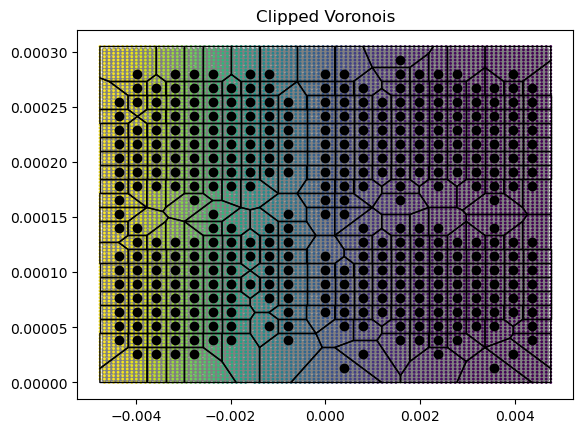

In [29]:



new_vertices = []
areas = []
points_df = pd.DataFrame(points, columns=['x', 'z'])
points_df = points_df.assign(area=np.nan, J_val_mean=np.nan, current=np.nan)
print(points_df)

for region_indx, region in enumerate(regions):
    polygon = vertices[region]
    shape = list(polygon.shape)
    shape[0] += 1
    clipped_poly = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)

    
    # ! Should not get here...
    if clipped_poly.is_empty:
        area = 0.0
        coords = []
        print(f"WARNING! Skipping region {region_indx} due to infinite or empty region")
    else:
        # area = clipped_poly.area* z_scaling * y_scaling
        coords = list(zip(*clipped_poly.exterior.coords.xy))
        
        
        # Scale back the polygons
        coords_arr = np.array(coords)
        coords_scaledback = np.zeros_like(coords_arr)
        coords_scaledback[:, 0] = coords_arr[:, 0] * x_scaling + xmin
        coords_scaledback[:, 1] = coords_arr[:, 1] * z_scaling + zmin
        
        polygon_scaledback = Polygon(coords_scaledback)
        area = polygon_scaledback.area
        
        # Find the index associated with the region in the points_df. Do this by checking if the points are within the polygon
        # Iterate through each point
        for i, row in points_df.iterrows():
            point = Point(row['x'], row['z'])
            if point.within(polygon_scaledback):
                point_index = i
        
        # plot the scaled polygon
        plt.plot(*zip(*coords_scaledback), 'k-', lw=1)
        
        
        points_within = interpolated_df[
            interpolated_df.apply(
                lambda row: polygon_scaledback.contains(Point(row['x'], row['z'])),
                axis=1
            )
        ]
        # print(f"points_within: {points_within}")
        # Plot these points
        plt.scatter(points_within['x'], points_within['z'], c='gray', s=10)
        
        # Get the average J value for the polygon
        J_val_mean = np.nanmean(points_within['J'])
        current = J_val_mean * area
        # Add the area, J_val_mean, and current to the points_df
        points_df.at[point_index, 'area'] = area
        points_df.at[point_index, 'J_val_mean'] = J_val_mean
        points_df.at[point_index, 'current'] = current
        
        print(f"Current: {current}, area: {area}, J_val_mean: {J_val_mean}")
        

    # new_vertices.append(coords)
    # areas.append(area)

    if coords:
        # plt.fill(*zip(*coords), alpha=0.4)
        pass

# Overplot the grid of points fromthe interpolated_df
plt.scatter(interpolated_df['x'], interpolated_df['z'], c=interpolated_df['J'], cmap='viridis', s=1)

# plt.plot(points_norm[:, 0], points_norm[:, 1], 'ko')
plt.plot(points[:, 0], points[:, 1], 'ko')
plt.title("Clipped Voronois")

In [31]:
points_df['current'].sum()

np.float64(1724.9155423019777)

In [39]:
current_scaling_inner_coil = 119.9/points_df['current'].sum()
current_scaling_outer_coil = 360/points_df['current'].sum()

print(f"Current scaling inner coil: {current_scaling_inner_coil}")
print(f"Current scaling outer coil: {current_scaling_outer_coil}")

points_df_inner_coil = points_df.copy()
points_df_outer_coil = points_df.copy()

for df, scaling, label in zip([points_df_inner_coil, points_df_outer_coil], [current_scaling_inner_coil, current_scaling_outer_coil], ['inner', 'outer']):
    
    # Add indexing to the dataframe
    df['particle_index'] = points_df.apply(
    lambda row: startpoints_df[
        (startpoints_df['x'] == row['x']) & (startpoints_df['z'] == row['z'])
    ].index[0] if not startpoints_df[
        (startpoints_df['x'] == row['x']) & (startpoints_df['z'] == row['z'])
    ].empty else None,
    axis=1
    )
    
    # Add the current scaling
    df['current_scaled'] = df['current'] * scaling
    
    # Sort
    df.sort_values(by='particle_index', inplace=True)
    
    # Check if any particle DOES not have an index
    print(f"Number of particles without an index: {df['particle_index'].isna().sum()}")
    # Check for any nans
    print(f"Number of nans in current_scaled: {df['current_scaled'].isna().sum()}")

    # Total current for the coil
    print(f"Total current for the {label} coil: {df['current_scaled'].sum()}")
    
    # Create a new dataframe with only the particle index and the current_scaled
    current_df = df[['particle_index', 'current_scaled']]
    
    
    # save the dataframe to a csv file
    current_df.to_csv(data.DIR_PATH / f'bitter_coil_particle_currents_{label}.csv', index=False)
    print()

Current scaling inner coil: 0.06951064968664382
Current scaling outer coil: 0.2087058706187804
Number of particles without an index: 0
Number of nans in current_scaled: 0
Total current for the inner coil: 119.9

Number of particles without an index: 0
Number of nans in current_scaled: 0
Total current for the outer coil: 360.0



In [34]:
points_df_inner_coil

,x,z,area,J_val_mean,current,particle_index,current_scaled
231,-0.004366,0.000038,1.323082e-08,7.197280e+08,9.522593,28,0.662474
143,-0.004366,0.000051,7.560469e-09,7.194141e+08,5.439108,29,0.378391
306,-0.004366,0.000063,7.560469e-09,7.194255e+08,5.439194,30,0.378397
50,-0.004366,0.000076,7.560469e-09,7.194343e+08,5.439261,31,0.378402
255,-0.004366,0.000089,7.560469e-09,7.194269e+08,5.439205,32,0.378398
...,...,...,...,...,...,...,...
98,0.004366,0.000216,7.560469e-09,5.171317e+08,3.909758,592,0.271996
307,0.004366,0.000229,7.560469e-09,5.170920e+08,3.909458,593,0.271976
234,0.004366,0.000241,7.560469e-09,5.170512e+08,3.909149,594,0.271954
210,0.004366,0.000254,7.560469e-09,5.170114e+08,3.908849,595,0.271933
